In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

class EnergyForecastPipeline:
    def __init__(self, config, filepath="data/Final_Energy_dataset.csv"):
        self.config = config
        self.filepath = filepath
        self.results = {}
        self.metrics = {}

    def load_data(self):
        df = pd.read_csv(self.filepath)
        df["Date"] = pd.to_datetime(df["Date"])
        
        # Identify all columns that start with "load_" or "pv_"
        load_cols = [col for col in df.columns if col.startswith("load_")]
        pv_cols = [col for col in df.columns if col.startswith("pv_")]
        
        # Extract building identifiers (everything after the underscore)
        load_ids = {col.split("_", 1)[1] for col in load_cols}
        pv_ids = {col.split("_", 1)[1] for col in pv_cols}
        
        # All building IDs present in either load or pv columns
        all_ids = load_ids.union(pv_ids)
        
        # Prepare a dictionary to hold the new prosumption columns
        prosumption_dict = {}
        
        for b in all_ids:
            load_col = "load_" + b if "load_" + b in df.columns else None
            pv_col = "pv_" + b if "pv_" + b in df.columns else None
            
            # Use the column data if it exists; if not, assume zero
            load_series = df[load_col] if load_col else 0
            pv_series = df[pv_col] if pv_col else 0
            
            prosumption_dict["prosumption_" + b] = load_series - pv_series
        
        # Create a DataFrame from the dictionary and concatenate with the original DataFrame
        prosumption_df = pd.DataFrame(prosumption_dict)
        df = pd.concat([df, prosumption_df], axis=1)
        
        return df

    def prepare_and_sequence_data(self, df, building_col):
        lookback = self.config.get("lookback", 48)
        include_time = self.config.get("include_time_features", False)
        if include_time:
            hours = df["Date"].dt.hour
            radians = hours / 24 * 2 * np.pi
            df["sin_hour"] = np.sin(radians)
            df["cos_hour"] = np.cos(radians)
            features = df[[building_col, "sin_hour", "cos_hour"]].values
        else:
            features = df[[building_col]].values
        target = df[building_col].values
        X_seq, y_seq, dates_seq = [], [], []
        for i in range(lookback, len(features)):
            X_seq.append(features[i - lookback : i])
            y_seq.append(target[i])
            dates_seq.append(df["Date"].iloc[i])
        X_seq = np.array(X_seq)
        y_seq = np.array(y_seq)

        mask = ~np.isnan(X_seq).any(axis=(1,2)) & ~np.isnan(y_seq)
        X_seq = X_seq[mask]
        y_seq = y_seq[mask]
        dates_seq = np.array(dates_seq)[mask]

        split_idx = int(0.8 * len(X_seq))
        return X_seq[:split_idx], y_seq[:split_idx], X_seq[split_idx:], y_seq[split_idx:], np.array(dates_seq[split_idx:])

    def build_model(self, input_shape):
        model = Sequential([
            Input(shape=input_shape),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.01),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        return model

    def train_model(self, model, X_train, y_train, epochs=100, batch_size=32, validation_split=0.2):
    
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[early_stopping], verbose=0)
        return history

    def predict(self, model, X):
        return model.predict(X, verbose=0).flatten()

    def calculate_metrics(self, y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        return {"mse": mse, "rmse": rmse, "mae": mae}

    def run_pipeline(self, building_col):
        df = self.load_data()
        X_train, y_train, X_test, y_test, dates_test = self.prepare_and_sequence_data(df, building_col)
        model = self.build_model(X_train.shape[1:])
        self.train_model(model, X_train, y_train, epochs=self.config.get("epochs", 100), batch_size=self.config.get("batch_size", 32))
        y_pred = self.predict(model, X_test)
        met = self.calculate_metrics(y_test, y_pred)
        self.results[building_col] = pd.DataFrame({"Date": dates_test, "actual": y_test, "predicted": y_pred})
        self.metrics[building_col] = met
        return model

    def aggregate_metrics(self, building_list):
        agg = []
        for b in building_list:
            m = self.metrics.get(b, {})
            m["building"] = b
            agg.append(m)
        return pd.DataFrame(agg)

    def plot(self, building_col, weeks=1):
        
        df_plot = self.results[building_col]
        timesteps = weeks * 7 * 48
        if len(df_plot) < timesteps:
            timesteps = len(df_plot)
        df_plot = df_plot.iloc[-timesteps:]
        plt.figure(figsize=(15, 5))
        plt.plot(df_plot["Date"], df_plot["actual"], label="Actual", color="blue")
        plt.plot(df_plot["Date"], df_plot["predicted"], label="Predicted", color="red")
        plt.xticks(rotation=0, fontsize=12)
        plt.yticks(fontsize=24)
        plt.title(building_col, fontsize=24)
        plt.xlabel("Date", fontsize=24)
        plt.ylabel("Energy", fontsize=24)
        plt.legend(prop={'size': 24}, ncol=2)
        plt.tight_layout()
        plt.show()

    def save_results(self,):
        save_path = self.config["save_path"]
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        agg_metrics = self.aggregate_metrics(list(self.results.keys()))
        agg_metrics.to_csv(os.path.join(save_path, "aggregated_metrics.csv"), index=False)

    def main(self,):
        df = self.load_data()
        building_cols = [col for col in df.columns if col.startswith(self.config["data_type"] + "_")]
        selected_buildings = building_cols[: self.config["num_buildings"]]
        for b in selected_buildings:
            print("Running forecast for", b)
            self.run_pipeline(b)
            print("Metrics for", b, ":", self.metrics[b])
            if self.config["visualize"]:
                self.plot(b, weeks=1)
        agg_metrics = self.aggregate_metrics(selected_buildings)
        print("Aggregated Metrics:")
        print(agg_metrics)
        self.save_results()

Running forecast for load_1
Metrics for load_1 : {'mse': 0.07134177015471124, 'rmse': np.float64(0.26709880223376375), 'mae': 0.18867156150279343}


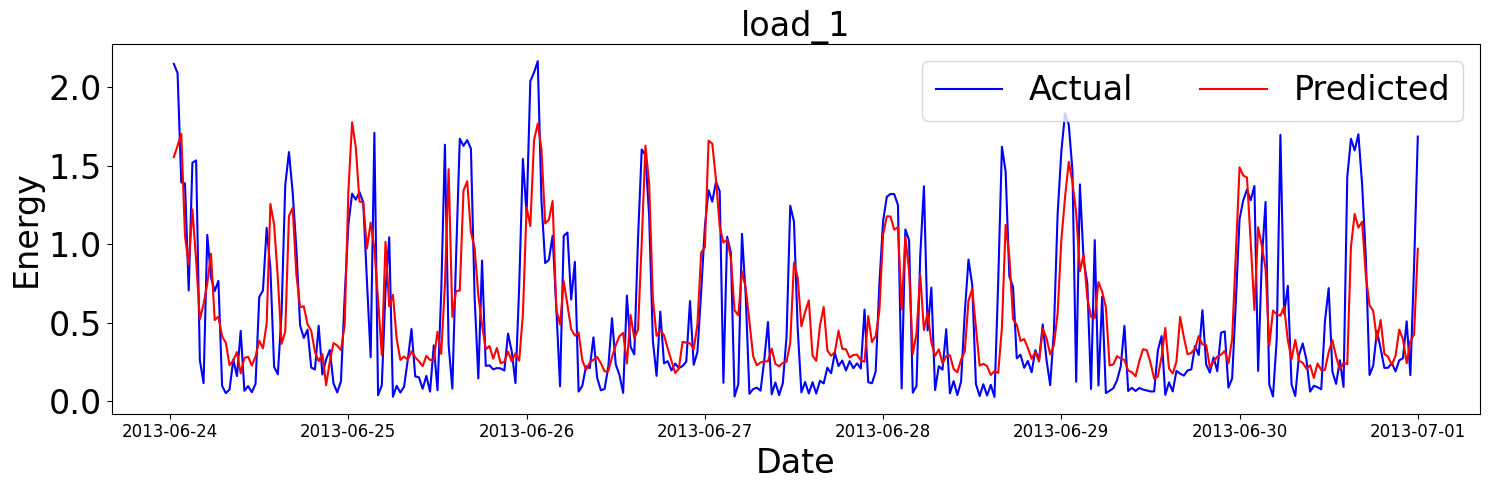

Running forecast for load_2
Metrics for load_2 : {'mse': 0.20607856003430647, 'rmse': np.float64(0.45395876468497276), 'mae': 0.26167137136736385}


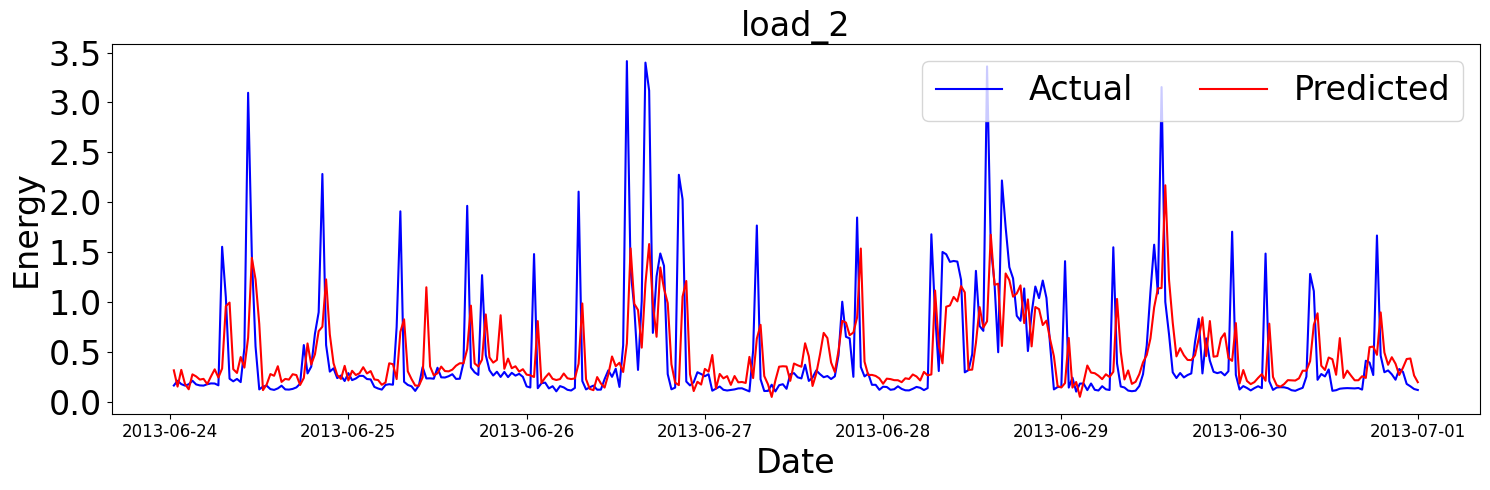

Aggregated Metrics:
        mse      rmse       mae building
0  0.071342  0.267099  0.188672   load_1
1  0.206079  0.453959  0.261671   load_2


In [ ]:
config = {
        "data_type": "load", #load, pv, prosumption
        "include_time_features": False, 
        "lookback": 48,
        "epochs": 100,
        "batch_size": 32,
        "num_buildings": 30,
        "visualize": True, 
        "save_path": "results/load_test/"
    }

pipeline = EnergyForecastPipeline(config)
pipeline.main()